# Imports

In [298]:
import pandas as pd
import numpy as np
import math

from sklearn.linear_model import LinearRegression
import torch

from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt

def make_report(y_pred , y_true):
    print ("")
    print ("Classification Report: ")
    print (classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plot_confusion_matrix(conf_mat=cm)
    plt.show()

# Classes

## base class

In [2]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None
    
    def forward(self, input_data):
        pass
    
    def backward(self, error, learning_rate):
        pass
    

## fully connected layer

In [3]:
class Fully_Connected_layer(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.uniform(low=-0.5, high=0.5, size=(input_size, output_size))
        self.bias = np.random.uniform(low=-0.5, high=0.5, size=(1, output_size))
        
    def forward(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output
    
    def backward(self, error, learning_rate):
        gradient = np.dot(self.input.T, error)
        self.weights -= learning_rate * gradient
        self.bias -= learning_rate * error
        return np.dot(error, self.weights.T)

## activation layer

In [4]:
class Activation_Layer(Layer):
    def __init__(self, function, d_function):
        self.activation = function
        self.d_activation = d_function
    
    def forward(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output
    
    def backward(self, error, learning_rate):
        return self.d_activation(self.input) * error

## some activation functions

In [279]:
def relu(x):
    return x * (x > 0)

def d_relu(x):
    return (x > 0) * 1

def sign(x):
    return np.sign(x)

def d_sign(x):
    return np.ones(x.shape)

def tanh(x):
    return np.tanh(x);

def d_tanh(x):
    return 1-np.tanh(x)**2;

def softmax(x):
    expX = np.exp(x)
    return expX / expX.sum()

def d_softmax(x):
    temp = softmax(x)
    return temp *(1-temp)

def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

    
def d_sigmoid(x):
    temp = sigmoid(x)
    return temp*(1.0-temp)


def one_hot_encoding(idx, output_dim):
    x = np.zeros(output_dim, dtype=np.int)
    x[idx] = 1
    return x

## some loss functions

In [281]:
def mse(true, pred):
    return np.mean(np.power(true-pred, 2))

def d_mse(true, pred):
    return 2*(pred-true)/true.size

def cross_entropy(actual, predicted):
    actual = one_hot_encoding(actual, 6)
    predicted = predicted[0]
#     print(actual)
#     print(predicted)
    sum_score = 0.0
    for i in range(actual.shape[0]):
        sum_score += actual[i] * math.log(1e-15 + predicted[i])
    mean_sum_score = 1.0 / len(actual) * sum_score
    return -mean_sum_score

def d_cross_entropy(actual, predicted):
    actual = one_hot_encoding(actual, 6)
    predicted = predicted[0]
    return predicted - actual

## Network class

In [271]:
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.d_loss = None
    
    def set_loss_function(self, function, d_function):
        self.loss = function
        self.d_loss = d_function
        
    def add_layer(self, layer):
        self.layers.append(layer)
        
    def fit(self, x, y, epoch, learning_rate):
        errors = []
        for i in range(epoch):
            error = 0 
            for j in range(len(x)):
                output = x[j:j+1]
                for layer in self.layers:
#                     print(layer)
                    output = layer.forward(output)
                error += self.loss(y[j], output)
#                 print(error)
                d_error = self.d_loss(y[j], output)
                for layer in reversed(self.layers):
                    d_error = layer.backward(d_error, learning_rate)
            if i%100==0:
                print("epoch {} Done: error = {}".format(i+1,f"{(error/len(x)):,}"  ))
            errors.append(error/len(x))
        return errors
                
    def predict(self, x):
        result = []
        for i in range(len(x)):
            output = x[i:i+1]
            for layer in self.layers:
                output = layer.forward(output)
            result.append(output)
        return result
    

# Test Regression

In [8]:
x = pd.read_csv('datasets/University/NN-HW1/regression/x.csv')
y = pd.read_csv('datasets/University/NN-HW1/regression/y.csv')
data = x.copy()
data['label'] = y.values
print('data shape:',data.shape)
display(data.head(5))
X_train, X_test, y_train, y_test = train_test_split(data.drop(['label'], axis=1), data['label'], test_size=0.30, random_state=42)
print('X_train shape:', X_train.shape,'y_train shape:', y_train.shape, 'X_test shape:', X_test.shape,'y_test shape:', y_test.shape)
input_shape = X_train.shape[1]

data shape: (3526, 16)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,label
0,13.875714,15.846035,17.504397,44.633112,35.604307,46.238290,21.172622,63.202122,35.864571,21.311221,1.543828,7.145689,14.406381,16.538581,13.089846,106145.638002
1,17.650738,24.824824,27.635406,41.117084,42.592513,29.249432,46.661309,32.507310,22.775707,16.793246,1.630457,8.571680,12.071435,14.202441,15.135194,68257.394081
2,9.594263,26.784439,26.817986,38.882851,18.216575,32.188432,48.094099,43.649546,34.616287,23.528802,1.858223,7.323392,17.034133,13.515795,15.345748,74076.862566
3,18.164249,35.772034,21.047181,46.417855,33.656794,33.089732,27.491772,30.819831,33.437940,11.302883,1.319192,6.058686,6.904474,13.561897,19.088641,53895.565816
4,21.748969,21.161214,20.889309,26.759598,39.751001,35.032459,53.224752,47.362440,30.087273,16.128714,1.548673,4.920108,16.190713,19.762129,15.722387,91622.435726


X_train shape: (2468, 15) y_train shape: (2468,) X_test shape: (1058, 15) y_test shape: (1058,)


In [46]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,label
count,3526.000000,3526.000000,3526.000000,3526.000000,3526.000000,3526.000000,3526.000000,3526.000000,3526.000000,3526.000000,3526.000000,3526.000000,3526.000000,3526.000000,3526.000000,3526.000000
mean,21.150986,26.269388,20.663295,42.051490,30.629828,35.357367,46.519170,46.713005,28.660267,17.090980,1.610985,6.669260,13.273067,16.876746,17.877189,83384.082253
std,6.297671,7.472353,6.203000,9.077615,8.035404,11.424594,13.293552,12.987955,7.859213,5.253150,0.366673,1.842262,3.560154,4.600573,4.946224,18044.477016
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20000.000000
25%,16.912058,21.363404,16.549961,36.069811,25.149279,27.726137,37.734280,37.799401,23.351452,13.439396,1.363554,5.450294,10.860404,13.957419,14.517355,70997.640324
50%,21.043703,26.226728,20.618775,42.037565,30.775279,35.355776,46.640402,46.703582,28.641639,17.045697,1.618686,6.690342,13.294823,16.905427,17.916318,83192.332223
75%,25.423915,31.281689,24.833170,48.130982,36.086663,42.914989,55.024320,55.776646,33.996587,20.647079,1.860870,7.919667,15.700653,19.885114,21.335927,95431.851031
max,44.000000,54.000000,43.000000,72.000000,58.000000,79.000000,97.000000,88.000000,55.000000,36.000000,3.000000,13.000000,25.000000,32.000000,37.000000,150000.000000


### simple regression as baseline model

In [44]:
reg = LinearRegression()
reg.fit(X_train, y_train)
test_pred = reg.predict(X_test)
print(f"Test Error :{mse(y_test, test_pred):,}" )

Test Error :10,081,303.43779853


### perceptron

epoch 1 Done: error = 159,608,477.344188
epoch 101 Done: error = 97,667,442.12614787
epoch 201 Done: error = 82,215,402.92359369
epoch 301 Done: error = 70,032,948.99606879
epoch 401 Done: error = 60,429,032.55604792
epoch 501 Done: error = 52,858,257.865290985
epoch 601 Done: error = 46,890,476.23677116
epoch 701 Done: error = 42,186,513.67561845
epoch 801 Done: error = 38,478,935.038455814
epoch 901 Done: error = 35,556,873.48519621
epoch 1001 Done: error = 33,254,067.67060308
epoch 1101 Done: error = 31,439,428.48381375
epoch 1201 Done: error = 30,009,600.493690953
epoch 1301 Done: error = 28,883,096.33942567
epoch 1401 Done: error = 27,995,671.47959243
epoch 1501 Done: error = 27,296,677.032805532
epoch 1601 Done: error = 26,746,183.89544166
epoch 1701 Done: error = 26,312,715.049906272
epoch 1801 Done: error = 25,971,457.459563654
epoch 1901 Done: error = 25,702,852.13835134


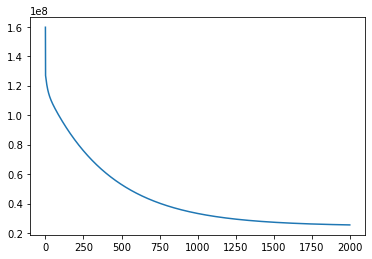

Test Error :41,863,718.3524295
Wall time: 2min 49s


In [45]:
%%time
model = Network()

model.add_layer(Fully_Connected_layer(input_shape, 1))

model.set_loss_function(mse, d_mse)
errs = model.fit(X_train.values.copy(), y_train.values.copy(), epoch=2000, learning_rate=0.00005)
plt.plot(errs)
plt.show()
pred = model.predict(X_test.values.copy())
r = []
for i in pred:
    r.append(i[0][0])
print(f"Test Error :{mse(y_test, r):,}" )

### MLP

epoch 1 Done: error = 358,760,516.69497234
epoch 101 Done: error = 331,319,038.95148253
epoch 201 Done: error = 331,319,038.95148253
epoch 301 Done: error = 331,319,038.95148253
epoch 401 Done: error = 331,319,038.95148253


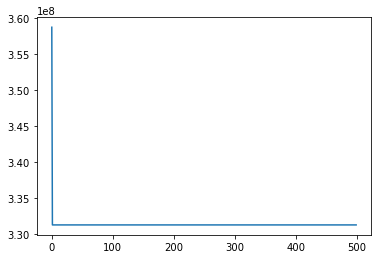

Test Error :336,259,507.9958309
Wall time: 2min 3s


In [68]:
%%time
model = Network()

model.add_layer(Fully_Connected_layer(input_shape, 100))
model.add_layer(Activation_Layer(relu, d_relu))
model.add_layer(Fully_Connected_layer(100, 50))
model.add_layer(Activation_Layer(tanh, d_tanh))
model.add_layer(Fully_Connected_layer(50,1))

model.set_loss_function(mse, d_mse)
errs = model.fit(X_train.values.copy(), y_train.values.copy(), epoch=500 , learning_rate=0.0005)
plt.plot(errs)
plt.show()
pred = model.predict(X_test.values.copy())
r = []
for i in pred:
    r.append(i[0][0])
print(f"Test Error :{mse(y_test, r):,}" )

### PyTorch: Perceptron

In [90]:
X_train_tensor = torch.tensor(X_train.values)
y_train_tensor = torch.tensor(y_train.values)
X_test_tensor = torch.tensor(X_test.values)
y_test_tensor = torch.tensor(y_test.values)

In [86]:
class Perceptron(torch.nn.Module):
    def __init__(self, input_size):
        super(Perceptron, self).__init__()
        self.input_size = input_size
        self.layer1 = torch.nn.Linear(self.input_size,1)
        
    def forward(self, x):
        output = self.layer1(x)
        return output

In [89]:
model = Perceptron(input_size = input_shape)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.00005)

epoch 0 Done: error = 42237008.0
epoch 100 Done: error = 42229488.0
epoch 200 Done: error = 42221984.0
epoch 300 Done: error = 42214484.0
epoch 400 Done: error = 42207004.0
epoch 500 Done: error = 42199532.0
epoch 600 Done: error = 42192076.0
epoch 700 Done: error = 42184636.0
epoch 800 Done: error = 42177204.0
epoch 900 Done: error = 42169788.0
epoch 1000 Done: error = 42162392.0
epoch 1100 Done: error = 42155008.0
epoch 1200 Done: error = 42147640.0
epoch 1300 Done: error = 42140280.0
epoch 1400 Done: error = 42132932.0
epoch 1500 Done: error = 42125600.0
epoch 1600 Done: error = 42118284.0
epoch 1700 Done: error = 42110972.0
epoch 1800 Done: error = 42103680.0
epoch 1900 Done: error = 42096392.0


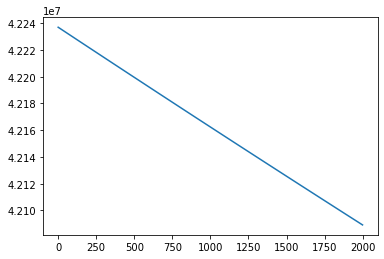

Test Error :44,078,244.0
Wall time: 832 ms


In [104]:
%%time
model.train()
errs = []
epoch = 2000

for epoch in range(epoch):    
    optimizer.zero_grad() 
    y_pred = model(X_train_tensor.float())
    loss = loss_function(y_pred.squeeze(), y_train_tensor.float())
    errs.append(loss.item())
    if epoch%100==0:
        print('epoch {} Done: error = {}'.format(epoch, loss.item()))
    loss.backward()
    optimizer.step()

plt.plot(errs)
plt.show()  
model.eval()
y_pred = model(X_test_tensor.float())
l = loss_function(y_pred.squeeze(), y_test_tensor.float())
print(f"Test Error :{l:,}" )

### PyTorch: MLP

In [112]:
class MLP(torch.nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.layer1 = torch.nn.Linear(self.input_size, 100)
        self.acc1 = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(100, 50)
        self.acc2 = torch.nn.Tanh()
        self.layer3 = torch.nn.Linear(50, 1)
        
    def forward(self, x):
        output = self.layer1(x)
        output = self.acc1(output)
        output = self.layer2(output)
        output = self.acc2(output)
        output = self.layer3(output)
        return output

In [113]:
model = MLP(input_size = input_shape)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.0005)

epoch 0 Done: error = 7250999296.0
epoch 100 Done: error = 321483392.0
epoch 200 Done: error = 321268224.0
epoch 300 Done: error = 321268192.0
epoch 400 Done: error = 321268192.0


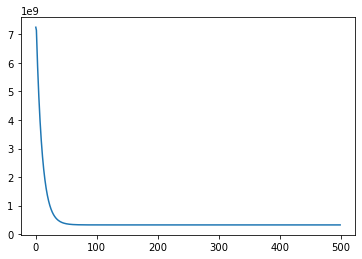

Test Error :335,471,872.0
Wall time: 1.86 s


In [114]:
%%time
model.train()
errs = []
epoch = 500

for epoch in range(epoch):    
    optimizer.zero_grad() 
    y_pred = model(X_train_tensor.float())
    loss = loss_function(y_pred.squeeze(), y_train_tensor.float())
    errs.append(loss.item())
    if epoch%100==0:
        print('epoch {} Done: error = {}'.format(epoch, loss.item()))
    loss.backward()
    optimizer.step()

plt.plot(errs)
plt.show()  
model.eval()
y_pred = model(X_test_tensor.float())
l = loss_function(y_pred.squeeze(), y_test_tensor.float())
print(f"Test Error :{l:,}" )

# Test Classification

In [118]:
x = pd.read_csv('datasets/University/NN-HW1/classification/features.csv')
y = pd.read_csv('datasets/University/NN-HW1/classification/labels.csv')
data = x.copy()
data['label'] = y.values
print('data shape:',data.shape)
display(data.head(5))
X_train, X_test, y_train, y_test = train_test_split(data.drop(['label'], axis=1), data['label'], test_size=0.30, random_state=42)
print('X_train shape:', X_train.shape,'y_train shape:', y_train.shape, 'X_test shape:', X_test.shape,'y_test shape:', y_test.shape)
input_shape = X_train.shape[1]
data.describe()

data shape: (9834, 18)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,label
0,81.894656,-67.647796,6.284543,-30.566285,-15.898834,3.840511,76.812480,-318.278049,-16.652295,47.886831,132.790978,13.012476,49.058326,-294.313125,58.858024,42.361804,-89.454799,1
1,-26.635394,82.968096,90.834092,-70.972767,-38.280643,12.748158,-82.128846,-209.817875,-64.891184,-43.006044,-9.238610,-3.711435,221.750187,-278.088841,80.551063,215.184683,15.349674,0
2,81.126182,521.179489,-204.213109,31.397725,52.385768,-3.613091,-144.281116,-100.937914,21.468080,22.805075,-65.918313,10.299397,-94.238758,-295.723200,65.897911,126.680189,-30.110383,2
3,74.706273,44.941183,119.720215,91.617409,-4.650815,-3.129639,-89.113528,226.362838,48.744206,-102.283730,-12.555976,0.380604,57.855131,-134.611445,-55.841913,38.723462,96.204834,2
4,74.331294,99.509204,18.448661,94.559138,21.079271,-2.226977,-31.596367,281.398872,-57.464879,-89.926860,-2.287027,10.837769,-36.442296,15.274938,90.394032,192.784326,110.922466,2


X_train shape: (6883, 17) y_train shape: (6883,) X_test shape: (2951, 17) y_test shape: (2951,)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,label
count,9834.000000,9834.000000,9834.000000,9834.000000,9834.000000,9834.000000,9834.000000,9834.000000,9834.000000,9834.000000,9834.000000,9834.000000,9834.000000,9834.000000,9834.000000,9834.000000,9834.000000,9834.000000
mean,12.598519,-31.868058,-11.200844,2.001290,-3.182115,0.776716,-10.699886,-16.392297,0.901572,0.913970,-0.298203,-3.252135,-13.640558,-69.938723,38.628288,79.775042,46.101258,1.013118
std,78.037603,233.346192,66.101646,90.559288,20.250882,5.093424,66.341119,173.466432,52.289486,86.260956,85.646896,21.055764,86.435873,134.467575,85.386577,139.158559,80.339559,0.843090
min,-280.759462,-936.648861,-254.203305,-374.326608,-81.591956,-21.204738,-266.289534,-550.744104,-226.932380,-332.931091,-316.639082,-100.004146,-282.206598,-582.555754,-304.513767,-471.736155,-325.094344,0.000000
25%,-36.754516,-183.495065,-56.788009,-58.739913,-16.992748,-2.633037,-54.368437,-137.855535,-33.900598,-57.385719,-57.533124,-16.870177,-73.439709,-160.627838,-18.643765,-14.196203,-6.458848,0.000000
50%,16.069656,-39.041641,-11.749304,2.753426,-3.177590,0.966234,-7.658362,-36.539169,1.237441,0.177253,0.594642,-3.362324,-19.780897,-70.788748,38.489216,80.739033,46.067194,1.000000
75%,64.330898,112.528044,33.156582,63.454551,10.725879,4.294718,35.888126,86.653688,36.650346,58.499223,58.400443,10.853788,38.249153,20.060935,96.433484,172.382244,98.492840,2.000000
max,297.019664,1060.022448,262.823664,342.078363,75.596577,19.346146,267.375109,690.744767,191.621092,325.356490,331.904030,80.394897,408.986388,497.446237,378.248240,691.280911,322.014503,5.000000


## MLP

epoch 1 Done: error = 3.2056823072842113


E:\ProgramData\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp


epoch 101 Done: error = 0.5389525911712246
epoch 201 Done: error = 0.3067409559849369
epoch 301 Done: error = 0.691797898832223


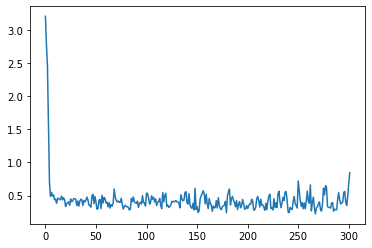


Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.96      0.89       999
           1       0.96      0.80      0.87       963
           2       0.97      0.95      0.96       973
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         5

    accuracy                           0.90      2951
   macro avg       0.46      0.45      0.45      2951
weighted avg       0.91      0.90      0.90      2951



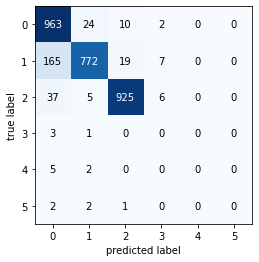

Wall time: 2min 53s


In [301]:
%%time
model = Network()

model.add_layer(Fully_Connected_layer(input_shape, 10))
model.add_layer(Activation_Layer(relu, d_relu))
model.add_layer(Fully_Connected_layer(10, 6))
model.add_layer(Activation_Layer(sigmoid, d_sigmoid))

model.set_loss_function(cross_entropy, d_cross_entropy)

errs = model.fit(X_train.values.copy(), y_train.values.copy(), epoch=302 , learning_rate=0.001)
plt.plot(errs)
plt.show()
pred = model.predict(X_test.values.copy())
r = []
for i in pred:
    r.append(i[0].argmax())

make_report(r, y_test)

## PyTorch: MLP

In [302]:
X_train_tensor = torch.tensor(X_train.values)
y_train_tensor = torch.tensor(y_train.values)
X_test_tensor = torch.tensor(X_test.values)
y_test_tensor = torch.tensor(y_test.values)

In [303]:
class MLP(torch.nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.layer1 = torch.nn.Linear(self.input_size, 10)
        self.acc1 = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(10, 6)
        self.acc2 = torch.nn.Sigmoid()
        
    def forward(self, x):
        output = self.layer1(x)
        output = self.acc1(output)
        output = self.layer2(output)
        output = self.acc2(output)
        return output

In [304]:
model = MLP(input_size = input_shape)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)

epoch 0 Done: error = 1.3287416696548462
epoch 100 Done: error = 1.3227243423461914
epoch 200 Done: error = 1.3168091773986816
epoch 300 Done: error = 1.3109662532806396
epoch 400 Done: error = 1.3053051233291626
epoch 500 Done: error = 1.299782395362854
epoch 600 Done: error = 1.2940760850906372
epoch 700 Done: error = 1.287719488143921
epoch 800 Done: error = 1.2806074619293213
epoch 900 Done: error = 1.272698163986206
epoch 1000 Done: error = 1.2631027698516846
epoch 1100 Done: error = 1.2574198246002197
epoch 1200 Done: error = 1.2529687881469727
epoch 1300 Done: error = 1.2488903999328613
epoch 1400 Done: error = 1.2452478408813477
epoch 1500 Done: error = 1.2419871091842651
epoch 1600 Done: error = 1.2391176223754883
epoch 1700 Done: error = 1.2365611791610718
epoch 1800 Done: error = 1.2341268062591553
epoch 1900 Done: error = 1.2317076921463013
epoch 2000 Done: error = 1.2293154001235962
epoch 2100 Done: error = 1.2270773649215698
epoch 2200 Done: error = 1.225032091140747
epoc

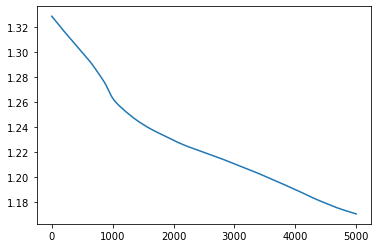

Test Error :1.1696197986602783

Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.77      0.82       999
           1       0.74      0.91      0.82       963
           2       0.92      0.84      0.88       973
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         5

    accuracy                           0.83      2951
   macro avg       0.42      0.42      0.42      2951
weighted avg       0.84      0.83      0.83      2951



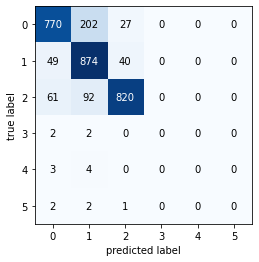

Wall time: 14.9 s


In [336]:
%%time
model.train()
errs = []
epoch = 5000

for epoch in range(epoch):    
    optimizer.zero_grad() 
    y_pred = model(X_train_tensor.float())
    loss = loss_function(y_pred.squeeze(), y_train_tensor.long())
    errs.append(loss.item())
    if epoch%100==0:
        print('epoch {} Done: error = {}'.format(epoch, loss.item()))
    loss.backward()
    optimizer.step()

plt.plot(errs)
plt.show()  
model.eval()
y_pred = model(X_test_tensor.float())
l = loss_function(y_pred.squeeze(), y_test_tensor.long())
print(f"Test Error :{l:,}" )
r = []
for i in y_pred.cpu().detach().numpy():
    r.append(i.argmax())

make_report(r, y_test)